In [1]:
import os
import pandas as pd
import numpy as np
import json
from datasets import Dataset, load_from_disk
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

MODEL_BASE = "microsoft/deberta-v3-base"
N_RUN = 0

# PATH_MODEL_TRAINED_BASE = f"checkpoints/{MODEL_BASE}/run_{N_RUN}/fold_"
PATH_DS_TRAIN_TOKENIZED = f"data/processed/{MODEL_BASE}/ds_train_tokenized"

PATH_DF_SCORES = "results/evaluation/df_scores.csv"

# Analyze folds results

In [2]:
def get_best_metric_from_fold(fold_id):
    path = f"checkpoints/{MODEL_BASE}/run_{N_RUN}/fold_{fold_id}/checkpoint-10240/trainer_state.json"
    try:
        with open(path, "r") as f:
            trainer_state = json.load(f)
        return trainer_state["best_metric"]
    except FileNotFoundError:
        print(f"File not found: {path}")
        return None

In [3]:
scores = [get_best_metric_from_fold(fold_id) for fold_id in range(5)]
scores

[0.988704817025802,
 0.9882707078896035,
 0.991930075119802,
 0.9900226678585309,
 0.9913572009696786]

In [4]:
np.mean(scores)

0.9900570937726835

In [5]:
np.std(scores)

0.0014296398089953676

The scores (ROC AUC macro) of the five folds are very high, with a mean of ~0.990057.

Also, there are very little differences between the five folds as it shows the small standard deviation (~0.001430), which means that not only the model get good results when generalizing, but also these good results does not depend on a specific batch.

The model generalizes very well.

# Learning curves

In [6]:
def get_fold_datasets(ds, fold):
    ds_train = ds.filter(lambda x: x["fold"] != fold)
    ds_val = ds.filter(lambda x: x["fold"] == fold)
    return ds_train, ds_val

In [7]:
def eval_checkpoint(fold_id, step, ds_train, ds_val):
    
    def _compute_metrics(eval_pred):
        logits, labels = eval_pred
        probs = 1 / (1 + np.exp(-logits))
        auc = roc_auc_score(labels, probs, average="macro")
        return {"roc_auc_macro": auc}

    # Load the model trained at given checkpoint
    path_checkpoint = f"checkpoints/{MODEL_BASE}/run_{N_RUN}/fold_{fold_id}/checkpoint-{step}"
    model_trained = AutoModelForSequenceClassification.from_pretrained(path_checkpoint).to("cuda")

    # Instantiate TrainingArguments and Trainer for evaluation
    eval_args = TrainingArguments(
        output_dir="./tmp_eval",
        per_device_eval_batch_size=32,
        dataloader_num_workers=2,
        fp16=True,
        save_strategy="no",
        evaluation_strategy="no",
    )
    eval_trainer = Trainer(model=model_trained, args=eval_args, compute_metrics=_compute_metrics)

    # Evaluate the model on the train and validation datasets
    metrics_train = eval_trainer.evaluate(eval_dataset=ds_train)
    metrics_val = eval_trainer.evaluate(eval_dataset=ds_val)

    return {
        "fold_id": fold_id,
        "step": step,
        "train_loss": metrics_train["eval_loss"],
        "val_loss": metrics_val["eval_loss"],
        "train_roc_auc_macro": metrics_train["eval_roc_auc_macro"],
        "val_roc_auc_macro": metrics_val["eval_roc_auc_macro"],
    }

In [8]:
# Load the tokenized dataset and get the train/validation splits
ds_train_tokenized = load_from_disk(PATH_DS_TRAIN_TOKENIZED)

In [9]:
scores = []
steps = [step for step in range(2048, 10241, 2048)]
for fold_id in range(1):
    print(f"Evaluating fold {fold_id}...")
    ds_train, ds_val = get_fold_datasets(ds_train_tokenized, fold_id)
    # scores += [eval_checkpoint(fold_id, step, ds_train, ds_val) for step in steps]
    for step in steps:
        print(f"\tEvaluating step {step}...")
        scores.append(eval_checkpoint(fold_id, step, ds_train, ds_val))
df_scores = pd.DataFrame(scores)
df_scores["epoch"] = df_scores["step"] / 11970
df_scores.insert(2, "epoch", df_scores.pop("epoch"))
df_scores.to_csv(PATH_DF_SCORES, index=False)

Evaluating fold 0...
	Evaluating step 2048...


/home/azureuser/ruben/toxicity_classificator/.venv/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


	Evaluating step 4096...


/home/azureuser/ruben/toxicity_classificator/.venv/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


	Evaluating step 6144...


/home/azureuser/ruben/toxicity_classificator/.venv/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


	Evaluating step 8192...


/home/azureuser/ruben/toxicity_classificator/.venv/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


	Evaluating step 10240...


/home/azureuser/ruben/toxicity_classificator/.venv/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## Plot results

In [20]:
fold_id = 0
df_filtered = df_scores[df_scores["fold_id"] == fold_id]

In [17]:
df_scores

,fold_id,step,epoch,train_loss,val_loss,train_roc_auc_macro,val_roc_auc_macro
0,0,2048,0.513283,0.044139,0.042472,0.977510,0.982491
1,0,4096,1.026566,0.037986,0.036825,0.985005,0.988562
2,0,6144,1.539850,0.037081,0.035924,0.989141,0.990897
3,0,8192,2.053133,0.034969,0.033570,0.990529,0.992259
4,0,10240,2.566416,0.032545,0.031328,0.991501,0.992894


In [15]:
import math
math.ceil(len(ds_train) / 32)

3990

In [16]:
df_scores["epoch"] = df_scores["step"] / 3990

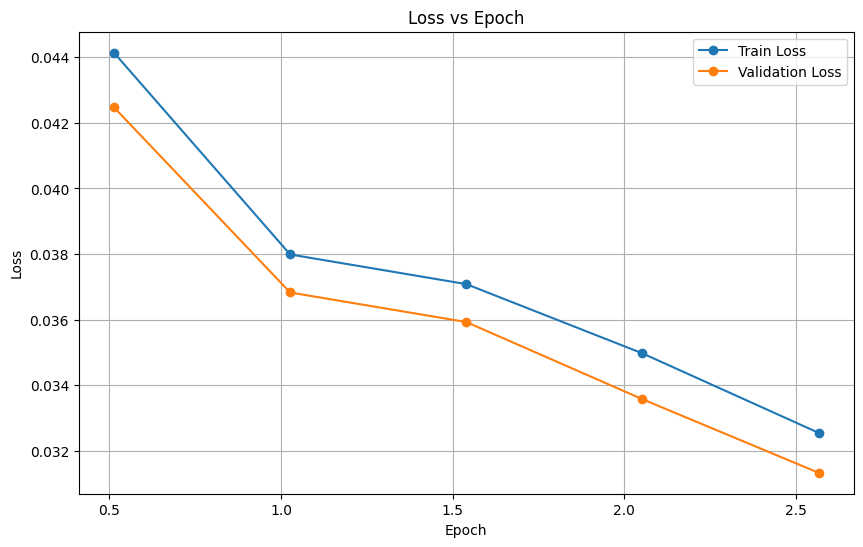

In [21]:
# Loss vs Epoch Plot
plt.figure(figsize=(10, 6))
plt.plot(df_filtered["epoch"], df_filtered["train_loss"], marker="o", label='Train Loss')
plt.plot(df_filtered["epoch"], df_filtered["val_loss"], marker="o", label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.grid(True)

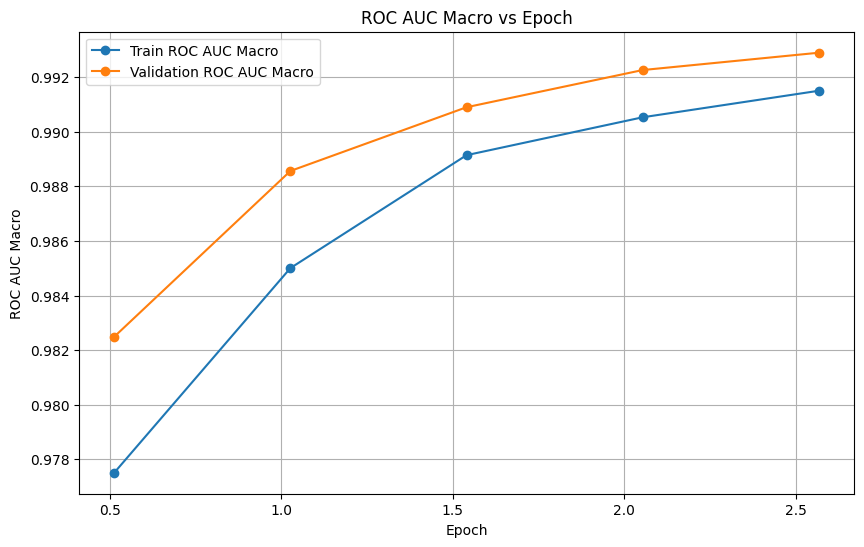

In [22]:
# ROC AUC vs Epoch Plot
plt.figure(figsize=(10, 6))
plt.plot(df_filtered["epoch"], df_filtered["train_roc_auc_macro"], marker="o", label='Train ROC AUC Macro')
plt.plot(df_filtered["epoch"], df_filtered["val_roc_auc_macro"], marker="o", label='Validation ROC AUC Macro')
plt.xlabel("Epoch")
plt.ylabel("ROC AUC Macro")
plt.title("ROC AUC Macro vs Epoch")
plt.legend()
plt.grid(True)

## Conclusions

TBD

In [13]:
# print("Train loss:", train_metrics["eval_loss"])
# print("Train AUC :", train_metrics["eval_roc_auc_macro"])
# print("Val   loss:", val_metrics["eval_loss"])
# print("Val   AUC :", val_metrics["eval_roc_auc_macro"])

Train loss: 0.030696088448166847
Train AUC : 0.9925534637672399
Val   loss: 0.03872407227754593
Val   AUC : 0.988704817025802